In [1]:
# 1. Core Libraries

import os
import datetime as dt
import warnings

warnings.filterwarnings("ignore")

# 2. Data Handling

import numpy as np
import pandas as pd

# 3. Visualization

import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = (12, 6)


# 4. Data Scaling

from sklearn.preprocessing import MinMaxScaler


# 5. Stock Market Data

import yfinance as yf


# 6. Deep Learning (TensorFlow / Keras)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


# 7. Reproducibility

np.random.seed(42)
tf.random.set_seed(42)

In [39]:

# 2. Data Fetching


# Choose stock ticker
# US example: "TCS.NS"
# Indian examples: "RELIANCE.NS", "TCS.NS"
TICKER = "TCS.NS"

START_DATE = "2015-01-01"
END_DATE = dt.datetime.now()

# Download historical stock data
df = yf.download(
    TICKER,
    start=START_DATE,
    end=END_DATE,
    progress=False
)

# Validate data download
if df.empty:
    raise ValueError("❌ No data fetched. Check ticker symbol or date range.")

# Reset index so Date becomes a column
df.reset_index(inplace=True)

# Keep only required OHLC columns
df = df[["Date", "Open", "High", "Low", "Close"]]

# Ensure Date column is datetime
df["Date"] = pd.to_datetime(df["Date"])

# Sort data chronologically (important for time series)
df.sort_values("Date", inplace=True)
df.reset_index(drop=True, inplace=True)

print("✅ Data fetched successfully!")
print("Data shape:", df.shape)
display(df.head())
display(df.tail())

✅ Data fetched successfully!
Data shape: (2740, 5)


Price,Date,Open,High,Low,Close
Ticker,,TCS.NS,TCS.NS,TCS.NS,TCS.NS
0,2015-01-01,997.212261,997.212261,987.111942,988.879517
1,2015-01-02,990.996947,1006.516461,990.841596,1002.049011
2,2015-01-05,1002.650988,1009.993105,980.760449,986.820679
3,2015-01-06,982.489342,982.489342,947.876281,950.440247
4,2015-01-07,959.530584,963.085082,935.231521,939.213379


Price,Date,Open,High,Low,Close
Ticker,,TCS.NS,TCS.NS,TCS.NS,TCS.NS
2735,2026-01-29,3200.100098,3200.100098,3125.600098,3144.399902
2736,2026-01-30,3141.000000,3141.000000,3092.000000,3123.899902
2737,2026-02-02,3198.000000,3198.000000,3134.000000,3169.600098
2738,2026-02-03,3350.000000,3350.000000,3186.300049,3225.300049
2739,2026-02-04,3120.000000,3120.000000,2986.000000,2999.100098


In [3]:
#Data exploration
print("Dataset Info:")
display(df.info())

print("\nStatistical Summary:")
display(df.describe())

print("\nMissing Values:")
display(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2740 entries, 0 to 2739
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   (Date, )         2740 non-null   datetime64[ns]
 1   (Open, TCS.NS)   2740 non-null   float64       
 2   (High, TCS.NS)   2740 non-null   float64       
 3   (Low, TCS.NS)    2740 non-null   float64       
 4   (Close, TCS.NS)  2740 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 107.2 KB


None


Statistical Summary:


Price,Date,Open,High,Low,Close
Ticker,,TCS.NS,TCS.NS,TCS.NS,TCS.NS
count,2740,2740.000000,2740.000000,2740.000000,2740.000000
mean,2020-07-21 07:08:19.270073088,2234.671471,2255.508200,2212.513206,2233.608259
min,2015-01-01 00:00:00,850.443832,859.724160,824.330718,844.116211
25%,2017-10-11 18:00:00,1065.459879,1075.369758,1053.968952,1062.955414
50%,2020-07-27 12:00:00,1959.669512,1980.449660,1938.067737,1959.145325
75%,2023-04-29 00:00:00,3137.285702,3160.045544,3109.257740,3134.896545
max,2026-02-04 00:00:00,4332.652506,4348.038052,4272.055967,4311.585449
std,NaN,1030.380329,1038.599852,1022.071129,1029.907289



Missing Values:


Price  Ticker
Date             0
Open   TCS.NS    0
High   TCS.NS    0
Low    TCS.NS    0
Close  TCS.NS    0
dtype: int64

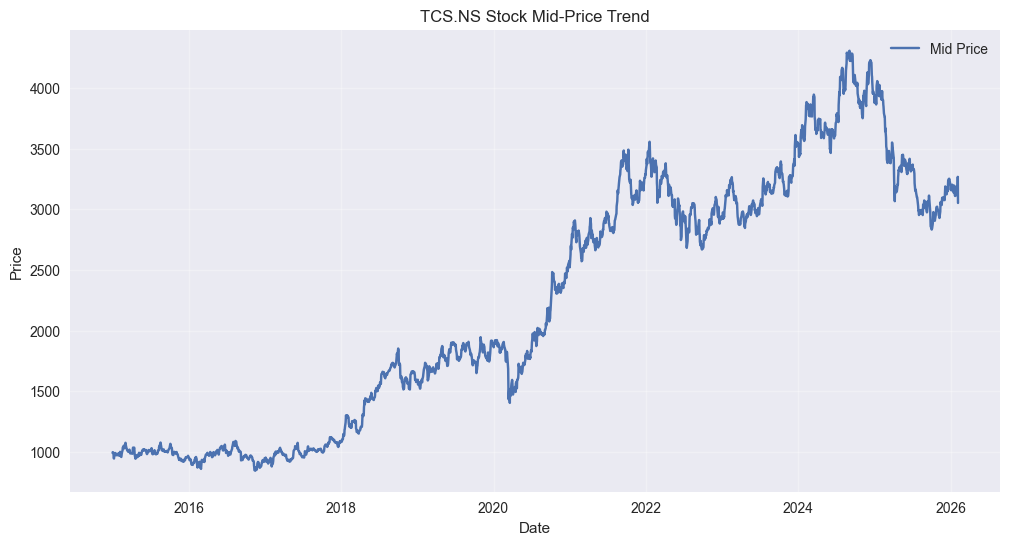

In [4]:
# Calculate mid price
df["Mid_Price"] = (df["Low"] + df["High"]) / 2

plt.figure()
plt.plot(df["Date"], df["Mid_Price"], label="Mid Price")

plt.title(f"{TICKER} Stock Mid-Price Trend")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [5]:
#Splitting Data Into a Training Set and a Test Set
## First calculate the mid prices from the highest and lowest

# Use Mid Price as the target feature
prices = df["Mid_Price"].values.reshape(-1, 1)

# Train-test split (time-series based, not random)
train_size = int(len(prices) * 0.8)

train_data = prices[:train_size]
test_data  = prices[train_size:]

print(f"Training samples: {train_data.shape[0]}")
print(f"Testing samples : {test_data.shape[0]}")

Training samples: 2192
Testing samples : 548


In [6]:
# "The dataset was split chronologically using an 80–20 ratio
#  to prevent future data leakage."

split_index = int(len(prices) * 0.8)

train_data = prices[:split_index]
test_data  = prices[split_index:]

print("Train data shape:", train_data.shape)
print("Test data shape :", test_data.shape)

Train data shape: (2192, 1)
Test data shape : (548, 1)


In [7]:
#Normalizing the Data
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data

scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on training data only
train_scaled = scaler.fit_transform(train_data)

# Transform test data using the same scaler
test_scaled = scaler.transform(test_data)

print("Training data scaled shape:", train_scaled.shape)
print("Testing data scaled shape :", test_scaled.shape)

Training data scaled shape: (2192, 1)
Testing data scaled shape : (548, 1)


In [8]:
# Train the Scaler with training data and smooth data
SMOOTHING_WINDOW = 50  # small, interpretable window

train_smoothed = pd.Series(train_scaled.flatten()).rolling(
    window=SMOOTHING_WINDOW,
    min_periods=1
).mean().values.reshape(-1, 1)

# Test data is NOT smoothed to avoid leakage
test_smoothed = test_scaled.copy()

print("Smoothed training data shape:", train_smoothed.shape)
print("Test data shape (unchanged):", test_smoothed.shape)

Smoothed training data shape: (2192, 1)
Test data shape (unchanged): (548, 1)


In [9]:
# 9. Final Data State Check
print("Train (raw) shape       :", train_data.shape)
print("Test (raw) shape        :", test_data.shape)

print("Train (scaled) shape    :", train_scaled.shape)
print("Test (scaled) shape     :", test_scaled.shape)

print("Train (smoothed) shape  :", train_smoothed.shape)
print("Test (final) shape      :", test_smoothed.shape)

Train (raw) shape       : (2192, 1)
Test (raw) shape        : (548, 1)
Train (scaled) shape    : (2192, 1)
Test (scaled) shape     : (548, 1)
Train (smoothed) shape  : (2192, 1)
Test (final) shape      : (548, 1)


In [10]:
# Exponential Moving Average (EMA) smoothing
gamma = 0.1  # smoothing factor (0 < gamma < 1)

ema_train = np.zeros_like(train_scaled)
ema_train[0] = train_scaled[0]

for t in range(1, len(train_scaled)):
    ema_train[t] = gamma * train_scaled[t] + (1 - gamma) * ema_train[t - 1]

print("EMA-smoothed training data shape:", ema_train.shape)

EMA-smoothed training data shape: (2192, 1)


In [11]:
# Combine EMA-smoothed train data and scaled test data
# (Used ONLY for visualization, not for training)

all_mid_data = np.concatenate(
    [ema_train, test_scaled],
    axis=0
)

print("Combined data shape:", all_mid_data.shape)

Combined data shape: (2740, 1)


In [12]:
#calculating Standard Average 

# ===============================
# 12. Baseline: Simple Moving Average (SMA)
# ===============================

WINDOW_SIZE = 100
N = len(ema_train)

sma_predictions = []
sma_actuals = []
mse_errors = []

for i in range(WINDOW_SIZE, N):
    # Prediction: mean of previous window
    prediction = np.mean(ema_train[i - WINDOW_SIZE : i])
    sma_predictions.append(prediction)

    # Actual value
    true_value = ema_train[i]
    sma_actuals.append(true_value)

    # Mean Squared Error
    mse_errors.append((prediction - true_value) ** 2)

# Final MSE
sma_mse = np.mean(mse_errors)

print(f"SMA Baseline MSE: {sma_mse:.6f}")

SMA Baseline MSE: 0.002602


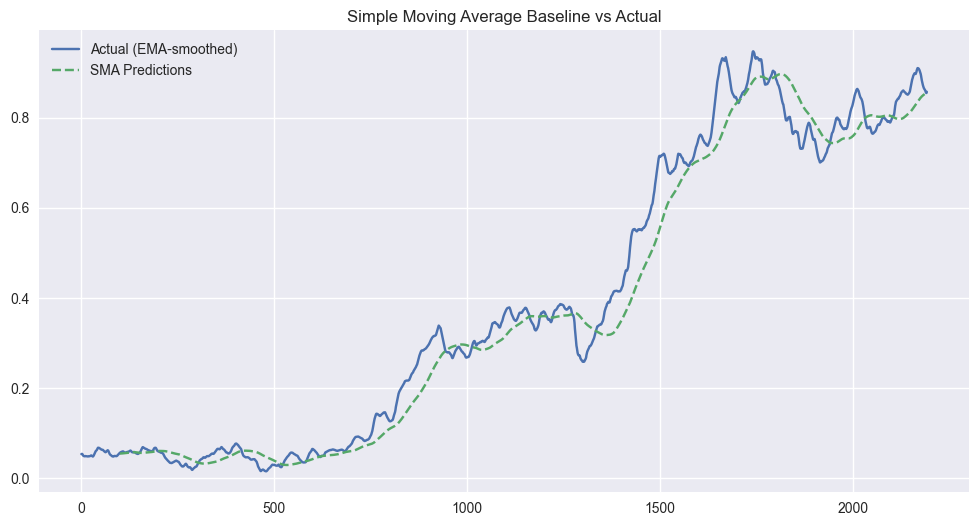

In [13]:
plt.figure()
plt.plot(ema_train, label="Actual (EMA-smoothed)")
plt.plot(
    range(WINDOW_SIZE, N),
    sma_predictions,
    label="SMA Predictions",
    linestyle="--"
)
plt.title("Simple Moving Average Baseline vs Actual")
plt.legend()
plt.show()

In [14]:
#Exponential moving average

N = len(ema_train)
ema_baseline_predictions = []
mse_errors = []

# Smoothing factor
alpha = 0.5  # higher = more weight on recent values

# Initialize EMA with first value
ema_value = ema_train[0]
ema_baseline_predictions.append(ema_value)

for t in range(1, N):
    ema_value = alpha * ema_train[t - 1] + (1 - alpha) * ema_value
    ema_baseline_predictions.append(ema_value)

    # Mean Squared Error
    mse_errors.append((ema_value - ema_train[t]) ** 2)

# Final MSE
ema_mse = np.mean(mse_errors)

print(f"EMA Baseline MSE: {ema_mse:.6f}")

EMA Baseline MSE: 0.000020


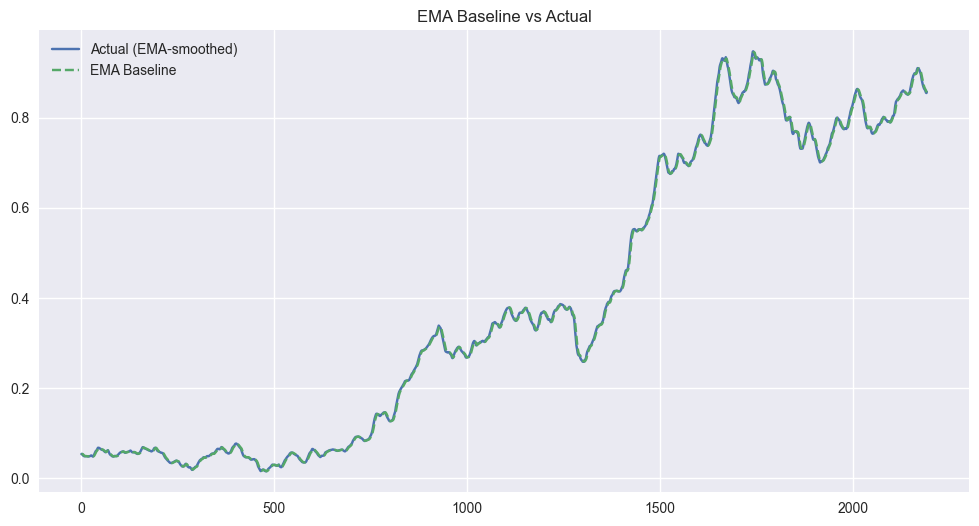

In [15]:
#Ploting EMA Prediction

plt.figure()
plt.plot(ema_train, label="Actual (EMA-smoothed)")
plt.plot(ema_baseline_predictions, label="EMA Baseline", linestyle="--")
plt.title("EMA Baseline vs Actual")
plt.legend()
plt.show()

In [16]:
#Data augmentation: a technique used to increase the size and diversity of a dataset by creating modified versions of existing data, instead of collecting new data.

#data generation in a sequence
def create_sequences(data, window_size):
    """
    Creates overlapping sequences for time-series forecasting.

    Parameters:
    - data: numpy array of shape (N, 1)
    - window_size: number of past timesteps

    Returns:
    - X: (samples, timesteps, features)
    - y: (samples, 1)
    """
    X, y = [], []

    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])
        y.append(data[i])

    return np.array(X), np.array(y)


# Sequence length (lookback window)
WINDOW_SIZE = 60

# Use EMA-smoothed training data
X_train, y_train = create_sequences(ema_train, WINDOW_SIZE)

# Use scaled test data (no smoothing, no leakage)
X_test, y_test = create_sequences(test_scaled, WINDOW_SIZE)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)

X_train shape: (2132, 60, 1)
y_train shape: (2132, 1)
X_test shape : (488, 60, 1)
y_test shape : (488, 1)


In [17]:
#testing the DATA Augmentation
sample_index = 0  # inspect first training sample

print("Input sequence shape:", X_train[sample_index].shape)
print("Target shape       :", y_train[sample_index].shape)

print("\nInput sequence (last 5 timesteps):")
print(X_train[sample_index][-5:].flatten())

print("\nTarget value:")
print(y_train[sample_index][0])

Input sequence shape: (60, 1)
Target shape       : (1,)

Input sequence (last 5 timesteps):
[0.06361438 0.06309936 0.06212275 0.06115983 0.06039295]

Target value:
0.05970670389939413


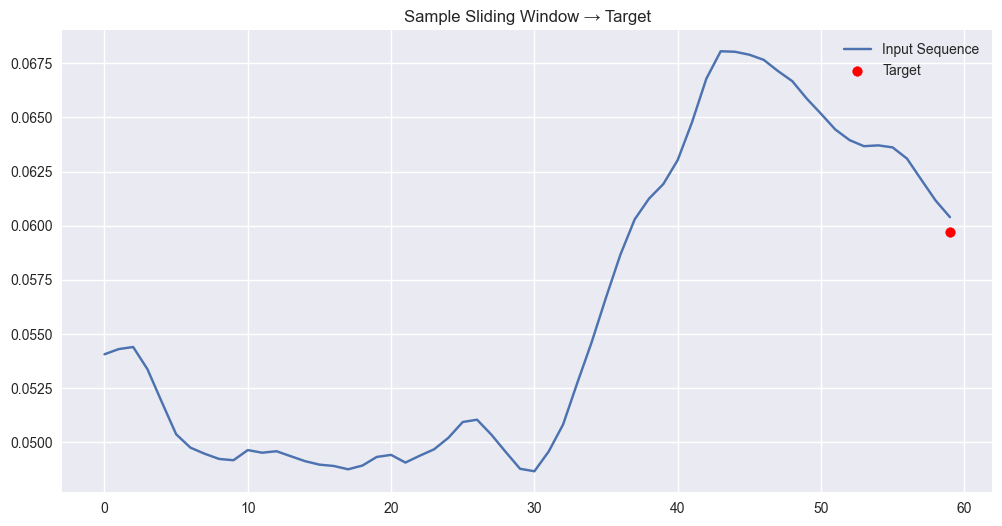

In [18]:
plt.figure()
plt.plot(X_train[sample_index], label="Input Sequence")
plt.scatter(
    len(X_train[sample_index]) - 1,
    y_train[sample_index],
    color="red",
    label="Target"
)
plt.title("Sample Sliding Window → Target")
plt.legend()
plt.show()

In [19]:
#define hyperparameters 
# Input data configuration
FEATURES = 1          # 1 feature: mid-price
TIME_STEPS = 60       # lookback window (must match sequence creation)

# Training configuration
BATCH_SIZE = 64
EPOCHS = 30

# LSTM architecture
LSTM_UNITS = [200, 200, 150]   # stacked LSTM layers
DROPOUT_RATE = 0.2

# Optimizer
LEARNING_RATE = 0.001

# Clear any previous models from memory
tf.keras.backend.clear_session()

print("Hyperparameters configured successfully.")

Hyperparameters configured successfully.


In [20]:
#Defining inputs and outputs

def create_sequences(data, time_steps):
    """
    Converts a time-series array into LSTM-ready sequences.

    Parameters:
    - data: numpy array of shape (N, 1)
    - time_steps: number of past timesteps to use

    Returns:
    - X: (samples, time_steps, features)
    - y: (samples, 1)
    """
    X, y = [], []

    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i])
        y.append(data[i])

    return np.array(X), np.array(y)

In [21]:
# Create sequences
X_train, y_train = create_sequences(ema_train, TIME_STEPS)
X_test, y_test   = create_sequences(test_scaled, TIME_STEPS)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)

X_train shape: (2132, 60, 1)
y_train shape: (2132, 1)
X_test shape : (488, 60, 1)
y_test shape : (488, 1)


In [22]:
# Defining the LSTM model and regression layer (Keras)

model = Sequential()

# LSTM Layer 1
model.add(
    LSTM(
        LSTM_UNITS[0],
        return_sequences=True,
        input_shape=(TIME_STEPS, FEATURES)
    )
)
model.add(Dropout(DROPOUT_RATE))

# LSTM Layer 2
model.add(
    LSTM(
        LSTM_UNITS[1],
        return_sequences=True
    )
)
model.add(Dropout(DROPOUT_RATE))

# LSTM Layer 3
model.add(
    LSTM(
        LSTM_UNITS[2]
    )
)
model.add(Dropout(DROPOUT_RATE))

# Output layer (Regression)
model.add(Dense(1))

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="mse"
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 200)        │       161,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 200)        │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 200)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 150)            │       210,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 150)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           151 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 693,151 (2.64 MB)

 Trainable params: 693,151 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
#Calculating LSTM output and feeding it to the regression layer to get the final prediction
# Loss calculation and optimizer


# Learning rate schedule (matches guide's exponential decay idea)
# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=1000,      # smoother decay
    decay_rate=0.9,
    staircase=True
)

# Adam optimizer with gradient clipping
optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
    clipnorm=5.0
)

# Compile model (regression task)
model.compile(
    optimizer=optimizer,
    loss="mse"
)

print("Model compiled successfully with LR scheduling and gradient clipping.")

Model compiled successfully with LR scheduling and gradient clipping.


In [24]:
# 20. Recursive Future Prediction


def predict_sequence(model, last_sequence, n_steps):
    """
    Predict future values recursively (one-step ahead).

    Parameters:
    - model         : trained Keras LSTM model
    - last_sequence : numpy array of shape (TIME_STEPS, 1)
    - n_steps       : number of future steps to predict

    Returns:
    - predictions   : numpy array of predicted values (n_steps,)
    """

    predictions = []
    current_seq = last_sequence.copy()

    for _ in range(n_steps):
        # Predict next step
        pred = model.predict(
            current_seq.reshape(1, TIME_STEPS, FEATURES),
            verbose=0
        )

        pred_value = pred[0, 0]
        predictions.append(pred_value)

        # Slide the window forward
        current_seq = np.roll(current_seq, -1, axis=0)
        current_seq[-1, 0] = pred_value

    return np.array(predictions)

In [25]:
# Create sequences for training and testing
# Training sequences (EMA-smoothed + scaled)
X_train, y_train = create_sequences(ema_train, TIME_STEPS)

# Testing sequences (scaled only, no smoothing)
X_test, y_test = create_sequences(test_scaled, TIME_STEPS)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)

X_train shape: (2132, 60, 1)
y_train shape: (2132, 1)
X_test shape : (488, 60, 1)
y_test shape : (488, 1)


In [26]:
# 22. Future Forecasting

# Take last sequence from test data
last_sequence = X_test[-1]

# Number of future steps to predict
FUTURE_STEPS = 30

# Predict future values (scaled)
future_predictions_scaled = predict_sequence(
    model,
    last_sequence,
    n_steps=FUTURE_STEPS
)

# Inverse scale predictions back to price scale
future_predictions = scaler.inverse_transform(
    future_predictions_scaled.reshape(-1, 1)
).flatten()

print("Future predictions (first 5):", future_predictions[:5])

Future predictions (first 5): [733.7837  734.7713  737.05365 740.4981  744.7992 ]


In [27]:
#Running the LSTM
#Prepare sequences

# DO NOT redefine TIME_STEPS
# It was already fixed in the hyperparameter cell

# Create sequences
X_train, y_train = create_sequences(ema_train, TIME_STEPS)
X_test, y_test   = create_sequences(test_scaled, TIME_STEPS)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape :", X_test.shape)
print("y_test shape :", y_test.shape)

X_train shape: (2132, 60, 1)
y_train shape: (2132, 1)
X_test shape : (488, 60, 1)
y_test shape : (488, 1)


In [28]:
#Train the model (Keras way)
# 24. Model Training

# Callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 218ms/step - loss: 0.0852 - val_loss: 0.0069
Epoch 2/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - loss: 0.0024 - val_loss: 0.0061
Epoch 3/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step - loss: 0.0013 - val_loss: 0.0030
Epoch 4/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 228ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 5/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 6/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 251ms/step - loss: 0.0012 - val_loss: 0.0022
Epoch 7/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 248ms/step - loss: 0.0012 - val_loss: 0.0090
Epoch 8/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 260ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 9/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 8s 236ms/step - loss: 0.0012 - val_loss: 0.0035
Epoch 10/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 252ms/step - loss: 0.0011 - val_loss: 0.0034
Epoch 11/30
34/34 ━━━━━━━━━━━━━━━━━━━━ 9s 255ms/step - loss: 0.0010 - val_loss: 0.0051


In [29]:
# Multi-Step Future Prediction (FINAL)

def predict_sequence(model, last_sequence, n_steps):
    """
    Recursive multi-step forecasting.

    Parameters:
    - model         : trained LSTM model
    - last_sequence : array of shape (TIME_STEPS, FEATURES)
    - n_steps       : number of future steps to predict

    Returns:
    - predictions   : array of predicted values (n_steps,)
    """

    predictions = []
    current_seq = last_sequence.copy()

    for _ in range(n_steps):
        # Predict next step
        pred = model.predict(
            current_seq.reshape(1, TIME_STEPS, FEATURES),
            verbose=0
        )

        pred_value = pred[0, 0]
        predictions.append(pred_value)

        # Slide window forward
        current_seq = np.roll(current_seq, -1, axis=0)
        current_seq[-1, 0] = pred_value

    return np.array(predictions)

In [30]:
# 26. Multi-Step Forecast Evaluation

# Evaluation settings
idx = 0                  # starting index in test set
N_PREDICT_ONCE = 30      # number of future steps to evaluate

# True future values (scaled)
true_future = y_test[idx : idx + N_PREDICT_ONCE].flatten()

# Predicted future values (scaled)
future_preds = predict_sequence(
    model,
    X_test[idx],
    n_steps=N_PREDICT_ONCE
)

# Mean Squared Error
mse = np.mean((future_preds - true_future) ** 2)

print(f"Multi-step Forecast MSE: {mse:.6f}")

Multi-step Forecast MSE: 0.005265


In [31]:
# Ensure same length (safety check)
min_len = min(len(true_future), len(future_preds))

true_future = true_future[:min_len]
future_preds = future_preds[:min_len]

# Inverse scale to original price space
true_future_inv = scaler.inverse_transform(
    true_future.reshape(-1, 1)
).flatten()

future_preds_inv = scaler.inverse_transform(
    future_preds.reshape(-1, 1)
).flatten()

print("Aligned length:", min_len)
print("First 5 actual prices   :", true_future_inv[:5])
print("First 5 predicted prices:", future_preds_inv[:5])

Aligned length: 30
First 5 actual prices   : [3858.7625597  3867.55465662 3837.19333724 3801.8845435  3771.85135762]
First 5 predicted prices: [3653.0671 3669.09   3680.3218 3686.8135 3689.188 ]


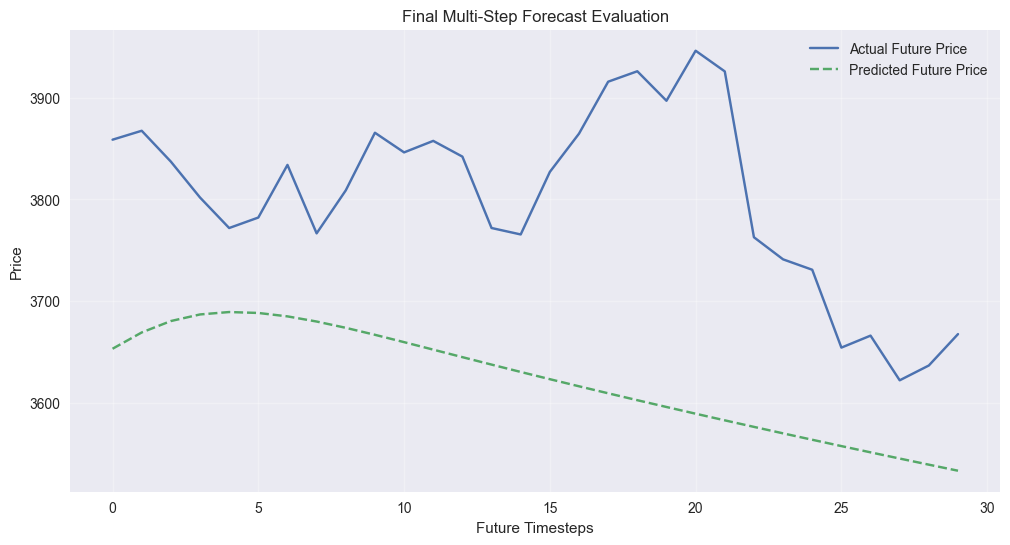

In [32]:
plt.figure()
plt.plot(true_future_inv, label="Actual Future Price")
plt.plot(future_preds_inv, label="Predicted Future Price", linestyle="--")
plt.title("Final Multi-Step Forecast Evaluation")
plt.xlabel("Future Timesteps")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Collect predictions over test set (for visualization)


PREDICTION_HORIZON = 30
STEP = 5  # how frequently we take test points

predictions_over_time = []
x_axis_seq = []

for i in range(0, len(X_test) - PREDICTION_HORIZON, STEP):
    preds = predict_sequence(
        model,
        X_test[i],
        n_steps=PREDICTION_HORIZON
    )
    predictions_over_time.append(preds)

    # x-axis indices for plotting
    x_axis_seq.append(
        list(range(i + TIME_STEPS, i + TIME_STEPS + PREDICTION_HORIZON))
    )

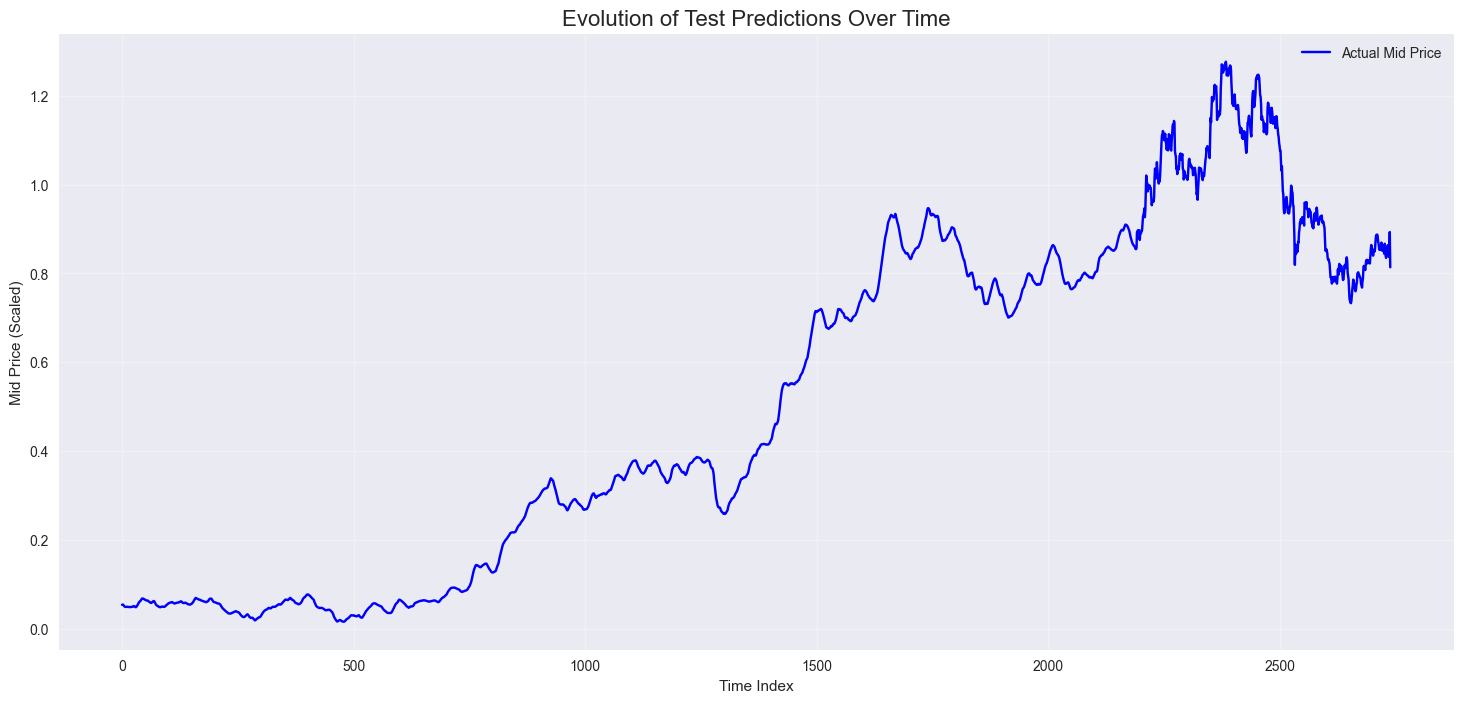

In [42]:
# Evolution of Test Predictions Over Time

plt.figure(figsize=(18, 8))

# Plot full mid-price history (scaled)
plt.plot(all_mid_data, color="blue", label="Actual Mid Price")

# Alpha fade: older predictions lighter, newer darker
start_alpha = 0.2
alphas = np.linspace(start_alpha, 1.0, len(predictions_over_time))

for i, preds in enumerate(predictions_over_time):
    for x, y in zip(x_axis_seq[i], preds):
        plt.plot(x, y, color="red", alpha=alphas[i])

plt.title("Evolution of Test Predictions Over Time", fontsize=16)
plt.xlabel("Time Index")
plt.ylabel("Mid Price (Scaled)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

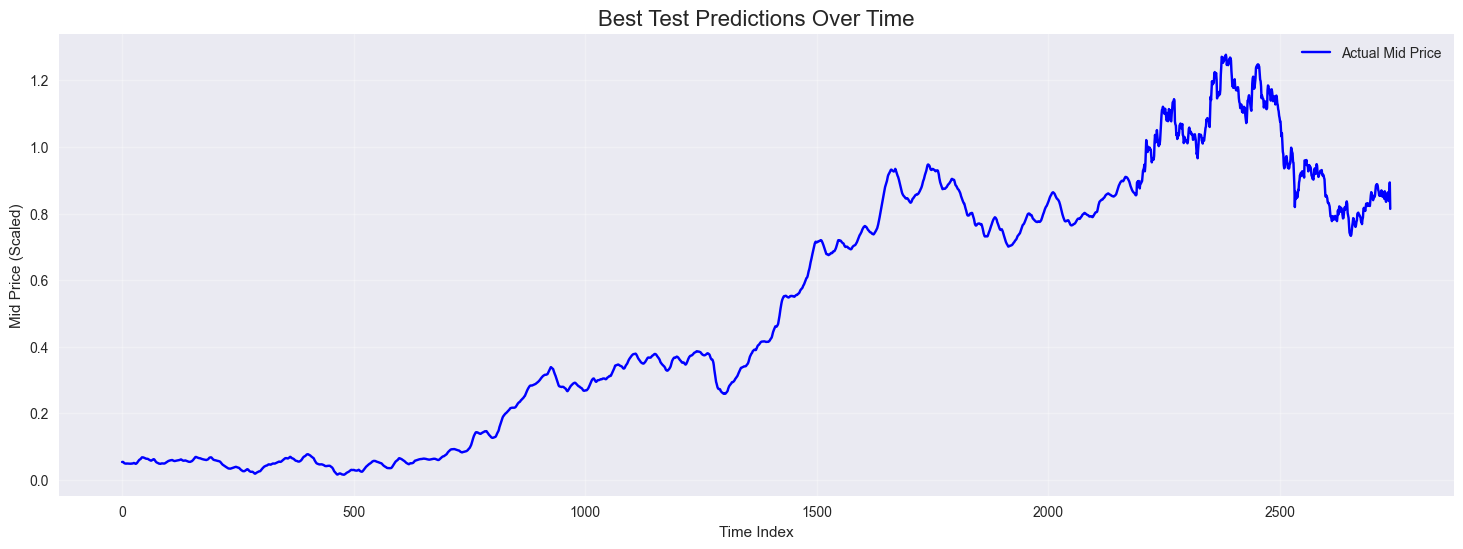

In [43]:
# Best Test Prediction Snapshot


best_idx = len(predictions_over_time) // 2

plt.figure(figsize=(18, 6))
plt.plot(all_mid_data, color="blue", label="Actual Mid Price")

for x, y in zip(x_axis_seq[best_idx], predictions_over_time[best_idx]):
    plt.plot(x, y, color="red")

plt.title("Best Test Predictions Over Time", fontsize=16)
plt.xlabel("Time Index")
plt.ylabel("Mid Price (Scaled)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()